In [53]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [54]:
torch.manual_seed(0)

In [55]:
dataroot = "data/mnist"

workers = 10

batch_size = 100

image_size = 32

nc = 1

num_classes = 10

nz = 100

ngf = 64

ndf = 64

num_epochs = 10

lr = 0.0002

beta1 = 0.5

In [56]:
train_data = datasets.MNIST(
    root=dataroot,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    download=True
)
test_data = datasets.MNIST(
    root=dataroot,
    train=False,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
dataset = train_data+test_data
print(f'Total Size of Dataset: {len(dataset)}')

Total Size of Dataset: 70000


In [57]:
dataloader = DataLoader (
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

In [58]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and 1 > 0) else 'cpu')

In [59]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

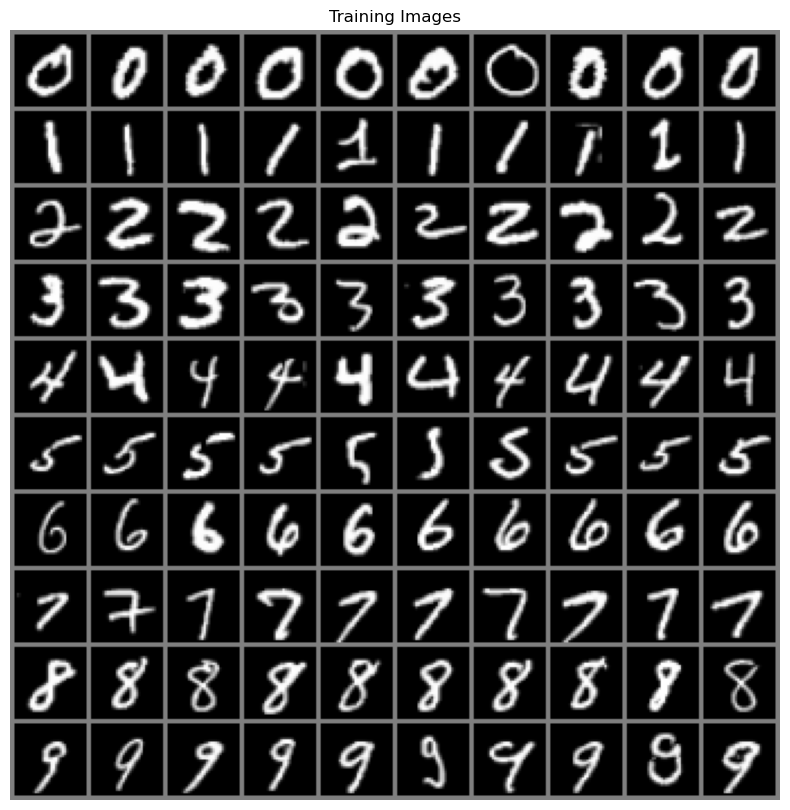

In [60]:
imgs = {}
for x, y in dataset:
    if y not in imgs:
        imgs[y] = []
    elif len(imgs[y])!=10:
        imgs[y].append(x)
    elif sum(len(imgs[key]) for key in imgs)==100:
        break
    else:
        continue
        
imgs = sorted(imgs.items(), key=lambda x:x[0])
imgs = [torch.stack(item[1], dim=0) for item in imgs]
imgs = torch.cat(imgs, dim=0)

plt.figure(figsize=(10,10))
plt.title("Training Images")
plt.axis('off')
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0)*0.5+0.5)

In [61]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )
        self.label = nn.Sequential(
            nn.ConvTranspose2d(num_classes, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

In [62]:
netG = Generator(1).to(device)

netG.apply(weights_init)

Generator(
  (image): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (label): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [63]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.label = nn.Sequential(
            nn.Conv2d(num_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.main = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

In [64]:
netD = Discriminator(1).to(device)

netD.apply(weights_init)

Discriminator(
  (image): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (label): Sequential(
    (0): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [65]:
criterion = nn.BCEWithLogitsLoss()

real_label_num = 1.
fake_label_num = 0.

label_1hots = torch.zeros(10,10)
for i in range(10):
    label_1hots[i,i] = 1
label_1hots = label_1hots.view(10,10,1,1).to(device)

label_fills = torch.zeros(10, 10, image_size, image_size)
ones = torch.ones(image_size, image_size)
for i in range(10):
    label_fills[i][i] = ones
label_fills = label_fills.to(device)

fixed_noise = torch.randn(100, nz, 1, 1).to(device)
fixed_label = label_1hots[torch.arange(10).repeat(10).sort().values]

In [66]:
import pytorch_lightning as pl

In [67]:
import torchvision.utils as vutils

In [68]:
img_list = []
G_losses = []
D_losses = []
D_x_list = []
D_z_list = []
loss_tep = 10

class CGAN(pl.LightningModule):
	def __init__(self):
		super().__init__()
		self.netD = Generator(1)

		self.netD.apply(weights_init)

		self.netG = Discriminator(1)

		self.netG.apply(weights_init)

		self.automatic_optimization = False

	def forward(self, z, y):
		return self.netG(z, y)

	def training_step(self, batch, batch_idx):
		X, y = batch

		g_optimizer, d_optimizer = self.optimizers()
		
		netD.zero_grad()
        
		real_image = batch[0].to(device)
		b_size = real_image.size(0)

		real_label = torch.full((b_size,), real_label_num, device=device)
		fake_label = torch.full((b_size,), fake_label_num, device=device)

		G_label = label_1hots[batch[1]]
		D_label = label_fills[batch[1]]

		output = netD(real_image, D_label)#.view(-1)
		print(output.shape)
		errD_real = criterion(output, real_label)
		errD_real.backward()
		D_x = output.mean().item()

		noise = torch.randn(b_size, nz, 1, 1, device=device)
		fake = netG(noise, G_label)
		output = netD(fake.detach(), D_label).view(-1)
		errD_fake = criterion(output, fake_label)
		errD_fake.backward()
		D_G_z1 = output.mean().item()
		errD = errD_real + errD_fake
		d_optimizer.step()

		netG.zero_grad()
		output = netD(fake, D_label).view(-1)
		errG = criterion(output, real_label)
		errG.backward()
		D_G_z2 = output.mean().item()
		g_optimizer.step()

		print(
			f'Step: [{i+1:0>{len(str(len(dataloader)))}}/{len(dataloader)}]',
			f'Loss-D: {errD.item():.4f}',
			f'Loss-G: {errG.item():.4f}',
			f'D(x): {D_x:.4f}',
			f'D(G(z)): [{D_G_z1:.4f}/{D_G_z2:.4f}]',
			end='\r'
		)

		self.log("Loss Discriminator", errD.item())
		self.log("Loss Generator", errG.item())

		G_losses.append(errG.item())
		D_losses.append(errD.item())

		D_x_list.append(D_x)
		D_z_list.append(D_G_z2)

		netG.eval()

		with torch.no_grad():
			fake = netG(fixed_noise, fixed_label)

		grid = vutils.make_grid(fake)
		self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

		return errG
	
	def configure_optimizers(self):
		optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
		optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
		return [optimizerG, optimizerD], []

In [69]:
model = CGAN()

trainer = pl.Trainer(max_epochs=10, accelerator="gpu", devices=1)

trainer.fit(model, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | netD | Generator     | 3.1 M 
1 | netG | Discriminator | 2.6 M 
---------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.873    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([100, 1, 1, 1])


ValueError: Target size (torch.Size([100])) must be the same as input size (torch.Size([100, 1, 1, 1]))

32 = 2 24.8 - 2.0376

16-mixed = 2 16.2 - 1.8702

16-true = 2 19.6 - 1.9103

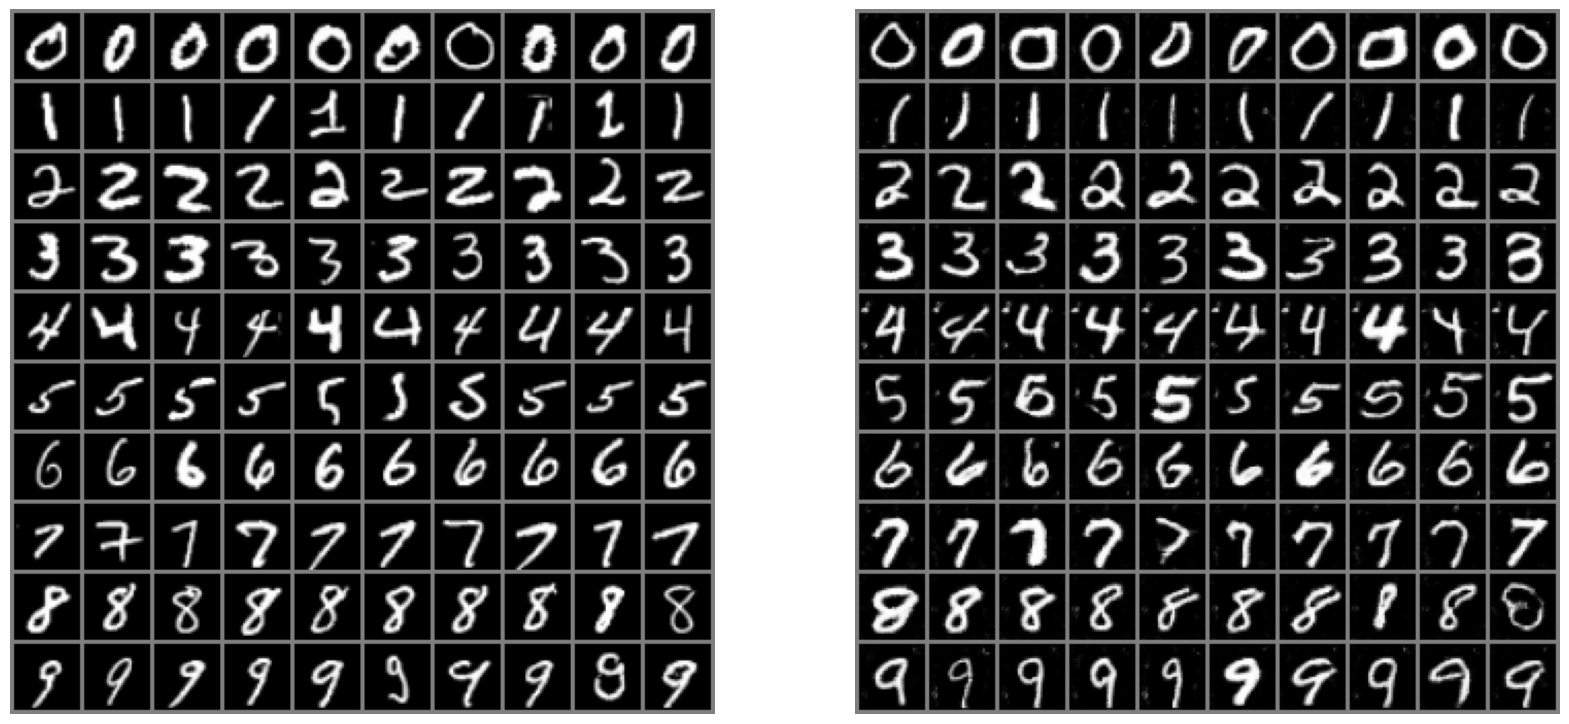

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.axis('off')
plt.title("")
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0)*0.5+0.5)

netG = Generator(1)
netG.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
netG.eval()

with torch.no_grad():
    fake = netG(fixed_noise.cpu(), fixed_label.cpu())

plt.subplot(1,2,2)
plt.axis("off")
plt.title("")
fake = utils.make_grid(fake, nrow=10)
plt.imshow(fake.permute(1, 2, 0)*0.5+0.5)

plt.savefig('result.jpg', bbox_inches='tight')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/